# Ensemble Model for Sugarcane Leaf Disease

## Data Processing

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (45).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (351).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (103).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (18).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (97).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (257).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (358).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (491).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (269).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (175).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (10).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (73).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (9).jpeg
/kaggle/input/sugarcane-leaf-disease-dataset/Yellow/yellow (303).jpeg
/kaggle/input/sugarcane-lea

In [2]:
pip install split-folders


Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import splitfolders
import shutil
import seaborn as sns
import plotly.express as px
import keras 
from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [4]:
path = "/kaggle/input/sugarcane-leaf-disease-dataset"
print(os.listdir(path))

['Yellow', 'Mosaic', 'Healthy', 'RedRot', 'Rust']


In [5]:
# Splitting the dataset into training, validation, and test sets
# path: The path to the dataset folder containing all the images
# seed: A seed value to ensure reproducibility of the split
# output: The output directory where the split datasets will be saved
# ratio: The ratio to split the dataset (60% training, 20% validation, 20% testing)

splitfolders.ratio(path, seed=1337, output="Sugarcane-Splitted", ratio=(0.6, 0.2, 0.2))

Copying files: 2521 files [00:13, 183.15 files/s]


In [6]:
import cv2

# Path to the image to be loaded
img_path = "/kaggle/working/Sugarcane-Splitted/train/Yellow/yellow (337).jpeg"

# Loading the image using OpenCV
image = cv2.imread(img_path)

# Checking if the image was successfully loaded
if image is not None:
    # Getting the shape (dimensions) of the image
    image_shape = image.shape
    print("Image shape:", image_shape)
else:
    # Error message if the image could not be loaded
    print("Error: Image not found or could not be loaded.")

Image shape: (1040, 493, 3)


### ImageDataGenerator

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating ImageDataGenerator objects for train, validation, and test sets
# rescale: Scaling pixel values to the range [0, 1] by dividing by 255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Defining the input shape (image dimensions and channels)
input_shape = (260, 123, 3)

# Paths to the training, validation, and testing directories
train_dir = '/kaggle/working/Sugarcane-Splitted/train'
val_dir = '/kaggle/working/Sugarcane-Splitted/val'
test_dir = '/kaggle/working/Sugarcane-Splitted/test'

# Augmenting the training data with various transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Rescale pixel values
    rotation_range=20,            # Random rotation within 20 degrees
    width_shift_range=0.2,        # Random horizontal shift by 20%
    height_shift_range=0.2,       # Random vertical shift by 20%
    shear_range=0.2,              # Shearing transformation
    zoom_range=0.2,               # Random zooming
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode='nearest'           # Filling in newly created pixels
)

# Validation data only rescaled (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Target size to which all images will be resized (224x224)
target_size = (224, 224)

# Generating batches of augmented image data from the training directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),       # Resizing images to 224x224
    batch_size=32,                # Batch size of 32
    class_mode='categorical'      # Multi-class classification
)

# Generating batches of validation data from the validation directory
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),       # Resizing images to 224x224
    batch_size=32,                # Batch size of 32
    class_mode='categorical'      # Multi-class classification
)

# Test data generator for evaluation (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generating batches of test data from the test directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),       # Resizing images to 224x224
    batch_size=32,                # Batch size of 32
    class_mode='categorical',     # Multi-class classification
    shuffle=False                 # Don't shuffle test data
)

# Checking the image dimensions from the training data generator
img_shape = train_generator.image_shape
print("Image dimensions:", img_shape)

Found 1511 images belonging to 5 classes.
Found 502 images belonging to 5 classes.
Found 508 images belonging to 5 classes.
Image dimensions: (224, 224, 3)


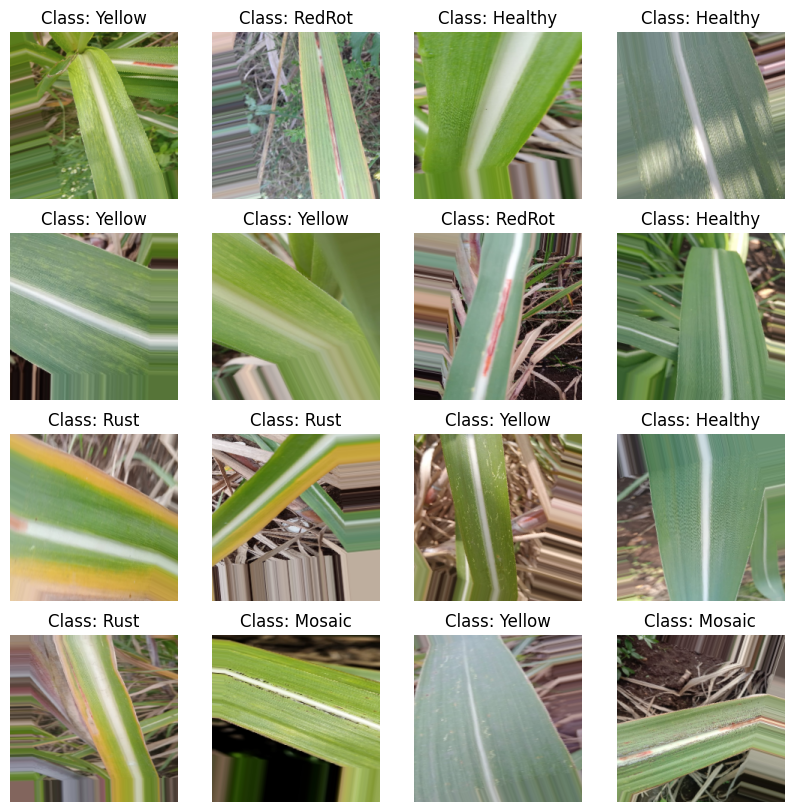

In [8]:
import matplotlib.pyplot as plt

# Function to display a grid of images from a data generator
def display_images(generator, num_rows=4, num_cols=4):
    # Retrieve a batch of images and their corresponding labels from the generator
    images, labels = next(generator)

    # Get the class indices mapping from the generator
    class_indices = generator.class_indices

    # List of class labels corresponding to the dataset
    CLASS_LABELS = ["Healthy", "Yellow", "RedRot", "Mosaic", "Rust"]

    # Generate class names based on the indices
    class_names = [CLASS_LABELS[index] for index in range(len(CLASS_LABELS))]

    # Create a figure for displaying images
    plt.figure(figsize=(10, 10))
    
    # Loop through the specified number of rows and columns to display images
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)  # Create a subplot for each image
        plt.imshow(images[i])                    # Display the image
        plt.title(f"Class: {class_names[np.argmax(labels[i])]}" )  # Title with the class name
        plt.axis('off')                          # Turn off axis

    # Show the plotted images
    plt.show()

# Calling the function to display images from the training generator
display_images(train_generator)

## First Model Architecture


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

# Creating a Sequential model for the CNN
model2 = Sequential()

# First convolutional layer: 32 filters, kernel size 3x3, ReLU activation
model2.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
# Batch normalization to stabilize learning
model2.add(BatchNormalization())
# Max pooling to down-sample the feature maps
model2.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer to reduce overfitting by randomly setting a fraction of input units to 0
model2.add(Dropout(0.25))

# Second convolutional layer: 64 filters, kernel size 3x3, ReLU activation
model2.add(Conv2D(64, (3, 3), activation='relu'))
# Batch normalization
model2.add(BatchNormalization())
# Max pooling
model2.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer
model2.add(Dropout(0.25))

# Third convolutional layer: 128 filters, kernel size 3x3, ReLU activation
model2.add(Conv2D(128, (3, 3), activation='relu'))
# Batch normalization
model2.add(BatchNormalization())
# Max pooling
model2.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer
model2.add(Dropout(0.25))

# Flattening the output to feed it into the dense layers
model2.add(Flatten())

# First dense layer: 512 units, ReLU activation
model2.add(Dense(512, activation='relu'))
# Batch normalization
model2.add(BatchNormalization())
# Dropout layer
model2.add(Dropout(0.5))

# Second dense layer: 256 units, ReLU activation
model2.add(Dense(256, activation='relu'))
# Batch normalization
model2.add(BatchNormalization())
# Dropout layer
model2.add(Dropout(0.5))

# Output layer: 5 units (one for each class), softmax activation for multi-class classification
model2.add(Dense(5, activation='softmax'))

# Compiling the model with categorical crossentropy loss, Adam optimizer, and accuracy as a metric
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Displaying the model's architecture summary
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,532,677 (169.88 MB)

 Trainable params: 44,530,693 (169.87 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Callback to save the model after every epoch if it shows improved validation accuracy
model_checkpoint = ModelCheckpoint(
    'inceptionv3_model.keras',    # File name to save the model
    monitor='val_accuracy',       # Monitor validation accuracy
    save_best_only=True,          # Save only the best model
    verbose=1,                    # Print messages when the model is saved
    mode='max'                    # Maximize the monitored quantity
)

# Callback to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # Monitor validation loss
    factor=0.1,                   # Reduce learning rate by a factor of 0.1
    patience=5,                   # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-8,                  # Minimum learning rate
    verbose=1                     # Print messages when learning rate is reduced
)

# Callback for early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=10,                  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True     # Restore model weights from the epoch with the best validation loss
)

# Number of epochs for training
epochs = 40

# Fitting the model on the training data and validating on the validation data
history = model2.fit(
    train_generator,              # Training data generator
    epochs=epochs,                # Number of epochs to train
    validation_data=val_generator, # Validation data generator
    callbacks=[reduce_lr, early_stopping, model_checkpoint] # List of callbacks to apply during training
)

Epoch 1/40


I0000 00:00:1728215372.630458      98 service.cc:145] XLA service 0x7a95dc0166a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728215372.630525      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/48 ━━━━━━━━━━━━━━━━━━━━ 14:58 19s/step - accuracy: 0.3438 - loss: 2.6592

I0000 00:00:1728215384.246362      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.3992 - loss: 2.0384
Epoch 1: val_accuracy improved from -inf to 0.18327, saving model to inceptionv3_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 765ms/step - accuracy: 0.4002 - loss: 2.0319 - val_accuracy: 0.1833 - val_loss: 22.1787 - learning_rate: 0.0010
Epoch 2/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.4630 - loss: 1.5987
Epoch 2: val_accuracy did not improve from 0.18327
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 514ms/step - accuracy: 0.4648 - loss: 1.5943 - val_accuracy: 0.1833 - val_loss: 21.3949 - learning_rate: 0.0010
Epoch 3/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.5127 - loss: 1.4103
Epoch 3: val_accuracy did not improve from 0.18327
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 506ms/step - accuracy: 0.5129 - loss: 1.4109 - val_accuracy: 0.1833 - val_loss: 22.2974 - learning_rate: 0.0010
Epoch 4/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5550 - loss: 1.2380
Epoch 4: val_accuracy did not improve from 

In [11]:
# Evaluating the trained model on the test data
test_loss, test_accuracy = model2.evaluate(test_generator)

# Printing the test loss
print(f'Test loss: {test_loss}')

# Printing the test accuracy
print(f'Test accuracy: {test_accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8606 - loss: 0.4296
Test loss: 0.4598177671432495
Test accuracy: 0.8503937125205994


In [12]:
model2.save('model2_84percentacc.h5')

## Using Pre Trained Models


### VGG16

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Loading the VGG16 model pre-trained on ImageNet without the top classification layers
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Creating a feature extractor model that outputs the feature maps from 'block4_pool'
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block4_pool').output)

# Freezing the layers of the feature extractor to prevent them from being updated during training
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding custom layers on top of the feature extractor for classification
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensionality
x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 units and ReLU activation
output = Dense(5, activation='softmax')(x)  # Output layer for 5 classes with softmax activation

# Creating the final model that combines the feature extractor and the custom layers
model16 = Model(inputs=feature_extractor.input, outputs=output)

# Compiling the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model16.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback to save the model if validation accuracy improves
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

# Callback to reduce learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(
    mode='min',                   # Minimize validation loss
    monitor='val_loss',          # Monitor validation loss
    factor=0.1,                  # Reduce learning rate by a factor of 0.1
    patience=5,                  # Wait for 5 epochs before reducing learning rate
    min_lr=1e-8,                 # Minimum learning rate
    verbose=1                    # Print messages when learning rate is reduced
)

# Callback for early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=10,                 # Stop training if no improvement for 10 epochs
    restore_best_weights=True    # Restore weights from the epoch with the best validation loss
)

# Displaying the model's architecture summary
model16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,165,701 (31.15 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [14]:
epochs = 17

history = model16.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/17
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.3538 - loss: 1.7709
Epoch 1: val_accuracy improved from -inf to 0.56574, saving model to model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 44s 666ms/step - accuracy: 0.3556 - loss: 1.7640 - val_accuracy: 0.5657 - val_loss: 1.1042 - learning_rate: 0.0010
Epoch 2/17
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.6194 - loss: 0.9900
Epoch 2: val_accuracy improved from 0.56574 to 0.62948, saving model to model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 67s 514ms/step - accuracy: 0.6195 - loss: 0.9897 - val_accuracy: 0.6295 - val_loss: 0.9371 - learning_rate: 0.0010
Epoch 3/17
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6367 - loss: 0.9065
Epoch 3: val_accuracy improved from 0.62948 to 0.66534, saving model to model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 519ms/step - accuracy: 0.6373 - loss: 0.9057 - val_accuracy: 0.6653 - val_loss: 0.8950 - learning_rate: 0.0010
Epoch 4/17
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7

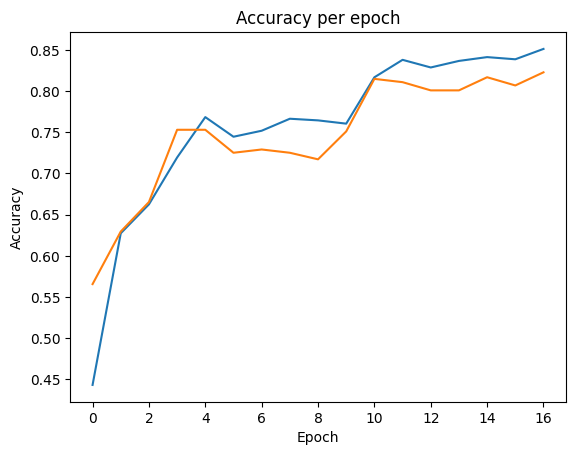

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

In [16]:
test_loss, test_accuracy = model16.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 674ms/step - accuracy: 0.7976 - loss: 0.5273
Test loss: 0.5099639892578125
Test accuracy: 0.8110235929489136


In [17]:
model16.save('82_test_acc.h5')

### MobileNetV2

In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Loading the MobileNetV2 model pre-trained on ImageNet without the top classification layers
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Creating a feature extractor model that outputs the final feature maps
feature_extractor = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.output)

# Freezing the layers of the feature extractor to prevent them from being updated during training
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding custom layers on top of the feature extractor for classification
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensionality
x = Dropout(0.5)(x)               # Dropout layer to reduce overfitting
x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 units and ReLU activation
x = Dense(512, activation='relu')(x)   # Dense layer with 512 units and ReLU activation
output = Dense(5, activation='softmax')(x)  # Output layer for 5 classes with softmax activation

# Creating the final model that combines the feature extractor and the custom layers
modelV2 = Model(inputs=feature_extractor.input, outputs=output)

# Compiling the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
modelV2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback to save the model if validation accuracy improves
model_checkpoint = ModelCheckpoint('mobilenet_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

# Callback to reduce learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss
    factor=0.1,                  # Reduce learning rate by a factor of 0.1
    patience=5,                  # Wait for 5 epochs before reducing learning rate
    min_lr=1e-8,                 # Minimum learning rate
    verbose=1                    # Print messages when learning rate is reduced
)

# Callback for early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=10,                 # Stop training if no improvement for 10 epochs
    restore_best_weights=True    # Restore weights from the epoch with the best validation loss
)

# Displaying the model's architecture summary
modelV2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,097,093 (15.63 MB)

 Trainable params: 1,839,109 (7.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
epochs = 40

history = modelV2.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.3166 - loss: 1.6198
Epoch 1: val_accuracy improved from -inf to 0.64542, saving model to mobilenet_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 692ms/step - accuracy: 0.3210 - loss: 1.6104 - val_accuracy: 0.6454 - val_loss: 0.9927 - learning_rate: 1.0000e-04
Epoch 2/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.6032 - loss: 1.0626
Epoch 2: val_accuracy improved from 0.64542 to 0.71315, saving model to mobilenet_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 516ms/step - accuracy: 0.6032 - loss: 1.0613 - val_accuracy: 0.7131 - val_loss: 0.7950 - learning_rate: 1.0000e-04
Epoch 3/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6545 - loss: 0.8995
Epoch 3: val_accuracy did not improve from 0.71315
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 504ms/step - accuracy: 0.6545 - loss: 0.8992 - val_accuracy: 0.6992 - val_loss: 0.7566 - learning_rate: 1.0000e-04
Epoch 4/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.70

In [20]:
test_loss, test_accuracy = modelV2.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 426ms/step - accuracy: 0.8320 - loss: 0.4737
Test loss: 0.48253920674324036
Test accuracy: 0.8208661675453186


### ResNet152

In [21]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Loading the ResNet152 model pre-trained on ImageNet without the top classification layers
resnet152_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers on top of the ResNet152 feature extractor for classification
x = resnet152_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensionality
x = Dropout(0.5)(x)               # Dropout layer to reduce overfitting
x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 units and ReLU activation
output = Dense(5, activation='softmax')(x)  # Output layer for 5 classes with softmax activation

# Creating the final model that combines the ResNet152 feature extractor and the custom layers
model152 = Model(inputs=resnet152_model.input, outputs=output)

# Freezing the layers of the ResNet152 model to prevent them from being updated during training
for layer in resnet152_model.layers:
    layer.trainable = False

# Compiling the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model152.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback to save the model if validation accuracy improves
model_checkpoint = ModelCheckpoint('resnet152_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

# Callback to reduce learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss
    factor=0.1,                  # Reduce learning rate by a factor of 0.1
    patience=5,                  # Wait for 5 epochs before reducing learning rate
    min_lr=1e-8,                 # Minimum learning rate
    verbose=1                    # Print messages when learning rate is reduced
)

# Callback for early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=10,                 # Stop training if no improvement for 10 epochs
    restore_best_weights=True    # Restore weights from the epoch with the best validation loss
)

# Displaying the model's architecture summary
model152.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 60,474,245 (230.69 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

### InceptionV3

In [22]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Loading the InceptionV3 model pre-trained on ImageNet without the top classification layers
inceptionv3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers on top of the InceptionV3 feature extractor for classification
x = inceptionv3_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensionality
x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 units and ReLU activation
predictions = Dense(5, activation='softmax')(x)  # Output layer for 5 classes with softmax activation

# Creating the final model that combines the InceptionV3 feature extractor and the custom layers
modelv3 = Model(inputs=inceptionv3_model.input, outputs=predictions)

# Freezing the layers of the InceptionV3 model to prevent them from being updated during training
for layer in inceptionv3_model.layers:
    layer.trainable = False

# Compiling the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
modelv3.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Displaying the model's architecture summary
modelv3.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 111, 111,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [23]:
# Define callbacks
model_checkpoint = ModelCheckpoint('inceptionv3_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
epochs = 40
history = modelv3.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)


Epoch 1/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.2035 - loss: 1.7055
Epoch 1: val_accuracy improved from -inf to 0.36454, saving model to inceptionv3_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 58s 852ms/step - accuracy: 0.2060 - loss: 1.7021 - val_accuracy: 0.3645 - val_loss: 1.4723 - learning_rate: 1.0000e-05
Epoch 2/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.3832 - loss: 1.4483
Epoch 2: val_accuracy improved from 0.36454 to 0.50000, saving model to inceptionv3_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 539ms/step - accuracy: 0.3846 - loss: 1.4463 - val_accuracy: 0.5000 - val_loss: 1.2982 - learning_rate: 1.0000e-05
Epoch 3/40
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5161 - loss: 1.2748
Epoch 3: val_accuracy improved from 0.50000 to 0.53586, saving model to inceptionv3_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 533ms/step - accuracy: 0.5168 - loss: 1.2738 - val_accuracy: 0.5359 - val_loss: 1.1922 - learning_rate: 1.0000e-05
Epoch 4/40
47/48 ━━

In [24]:
test_loss, test_accuracy = modelv3.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 583ms/step - accuracy: 0.8064 - loss: 0.5678
Test loss: 0.5938774347305298
Test accuracy: 0.787401556968689


## Ensemble Model


In [25]:
modelv3.save('inceptionv3_80.h5')

In [26]:
from tensorflow.keras.models import load_model


model1_VGG = load_model('/kaggle/working/82_test_acc.h5')
model2_mobile = load_model('/kaggle/working/mobilenet_model.keras')
model3 = load_model('/kaggle/working/inceptionv3_80.h5')
model4 = load_model('/kaggle/working/model2_84percentacc.h5')

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# List of models to be used for ensemble predictions
models = [model4, model1_VGG, model2_mobile, model3]

# True labels for the test dataset
true_labels = test_generator.classes

def simple_ensemble_predict(models, data_generator):
    # Make predictions for each model in the ensemble
    preds = [model.predict(data_generator) for model in models]
    
    # Convert list of predictions to a NumPy array
    preds_array = np.array(preds)
    
    # Average the predictions across all models
    avg_preds = np.mean(preds_array, axis=0)
    
    # Get the class with the highest average probability
    ensemble_preds = np.argmax(avg_preds, axis=1)
    
    return ensemble_preds

# Using the ensemble prediction function to get final predictions
ensemble_pred_labels = simple_ensemble_predict([model1_VGG, model2_mobile, model3, model4], test_generator)

# Calculate accuracy of the ensemble predictions
accuracy = accuracy_score(true_labels, ensemble_pred_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, ensemble_pred_labels)

# Generate classification report with precision, recall, and F1-score
class_report = classification_report(true_labels, ensemble_pred_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 491ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step


In [28]:
print(f'Ensemble model accuracy: {accuracy:.4f}')


Ensemble model accuracy: 0.9094


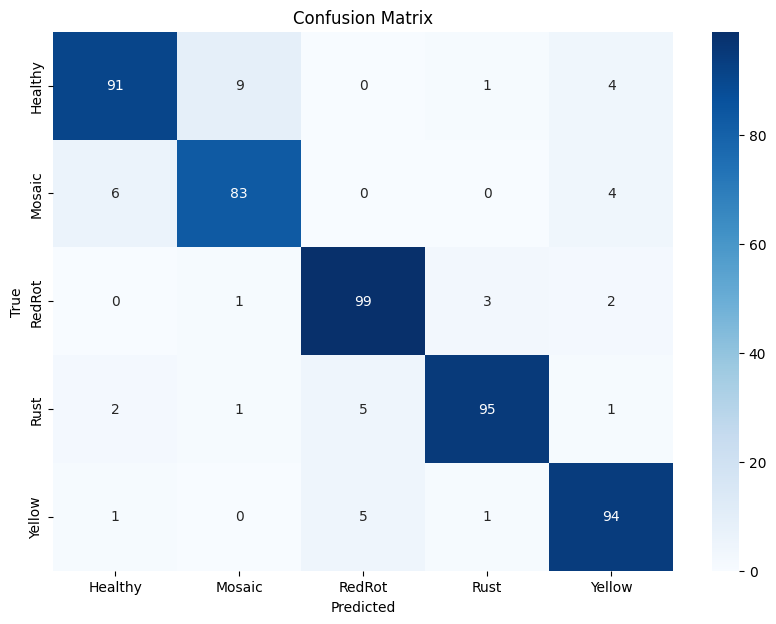

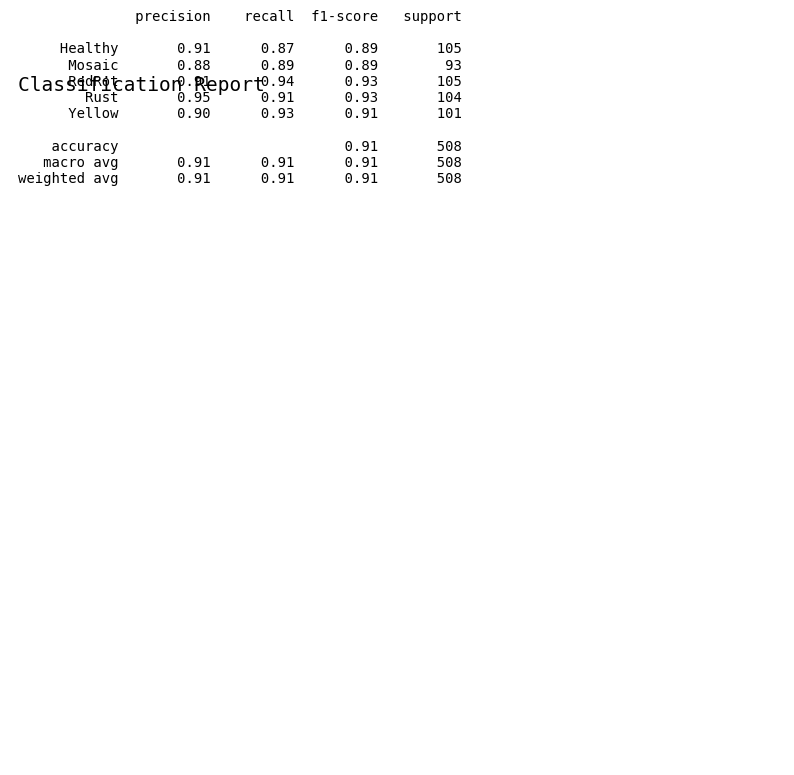

In [29]:
cm = conf_matrix  # Assigning the confusion matrix to a variable

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))  # Setting the figure size for the plot
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(),  # Setting x-tick labels to class names
            yticklabels=test_generator.class_indices.keys())  # Setting y-tick labels to class names
plt.xlabel('Predicted')  # Label for the x-axis
plt.ylabel('True')  # Label for the y-axis
plt.title('Confusion Matrix')  # Title of the plot
plt.show()  # Displaying the plot

# Generating a classification report string
classification_report_str = classification_report(true_labels, ensemble_pred_labels, target_names=test_generator.class_indices.keys())

# Plotting the Classification Report
plt.figure(figsize=(10, 7))  # Setting the figure size for the report
plt.text(0.01, 1.25, str('Classification Report'), {'fontsize': 14}, fontproperties='monospace') 
plt.text(0.01, 1.05, classification_report_str, {'fontsize': 10}, fontproperties='monospace') 
plt.axis('off')  # Hiding the axis
plt.show()  # Displaying the report